In [3]:
import cv2
import mmcv
import mmengine
import torch
import numpy as np

import virtual_camera as vc

import matplotlib.pyplot as plt
%matplotlib inline
# %matplotlib notebook

from pathlib import Path

In [4]:
from scipy.spatial.transform import Rotation

In [5]:
import sys
sys.path.insert(0, "../")

from prefusion.dataset.transform import Image

In [6]:
def get_cam_type(name):
    if 'perspective' in name.lower():
        return 'PerspectiveCamera'
    elif 'fisheye' in name.lower():
        return 'FisheyeCamera'
    else:
        raise ValueError('Unknown camera type')

In [7]:
data_root = Path('../data/')
info_file = '../data/20230823_110018/mv_4d_infos.pkl'

scenes = mmengine.load(info_file)
scene = scenes['20230823_110018']

frame_id = '1692759849564'
frame = scene['frame_info'][frame_id]

camera_images = {}
for camera_id in frame['camera_image']:
    data = {
        'cam_id': camera_id,
        'cam_type': get_cam_type(camera_id),
        'frame_id': frame_id,
    }
    data.update(scene['scene_info']['calibration'][camera_id])
    data['img'] = mmcv.imread(data_root / frame['camera_image'][camera_id])
    data['ego_mask'] = mmcv.imread(
        data_root / scene['scene_info']['camera_mask'][camera_id], flag='grayscale'
    )
    camera_images[camera_id] = Image(data)
        

In [8]:
# image_data = camera_images['VCAMERA_FISHEYE_FRONT'].data
image_data = camera_images['VCAMERA_PERSPECTIVE_FRONT_LEFT'].data

In [9]:
image_data['extrinsic'], image_data['intrinsic']

((array([[ 7.07106781e-01,  1.11022302e-16,  7.07106781e-01],
         [-7.07106781e-01,  1.11022302e-16,  7.07106781e-01],
         [ 0.00000000e+00, -1.00000000e+00,  2.22044605e-16]]),
  array([2.09698729, 1.06778281, 1.01063169])),
 (639.5, 479.5, 640.0, 640.0))

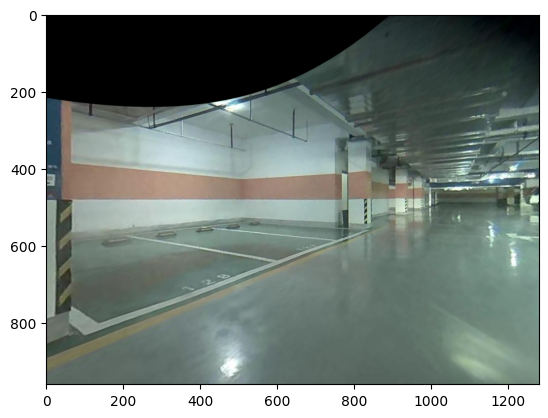

In [10]:
plt.imshow(image_data['img'][..., ::-1])

In [45]:
downscale = 32
resolution = np.array(image_data['img'].shape[:2][::-1])
intrinsics = np.array(image_data['intrinsic'])

resolution = resolution // downscale
intrinsics[:4] /= downscale


In [46]:
resolution, intrinsics

(array([40, 30]), array([19.984375, 14.984375, 20.      , 20.      ]))

In [47]:
camera_class = getattr(vc, image_data['cam_type'])
camera = camera_class(
    resolution,
    image_data['extrinsic'],
    intrinsics,
)

In [48]:
camera_points = camera.unproject_points_from_image_to_camera()
# normalize rays
camera_points /= np.linalg.norm(camera_points, axis=0)[None]

In [68]:
# ray distance clips

max_distance = 16
num_channel_depth = int(max_distance * 0.3)

drange = np.linspace(0, max_distance, num_channel_depth + 1)[1:]

In [69]:
camera_points.shape, drange.shape

((3, 1200), (4,))

In [70]:
frustum = camera_points[..., None] * drange[None]
# frustum = frustum.reshape(3, -1)

# frustrum = np.repeat(camera_points[..., None], num_channel_depth, axis=-1) 
# frustrum *= drange[None, None]
# frustrum = frustrum.reshape(3, -1)


In [71]:
P, N, D = frustum.shape

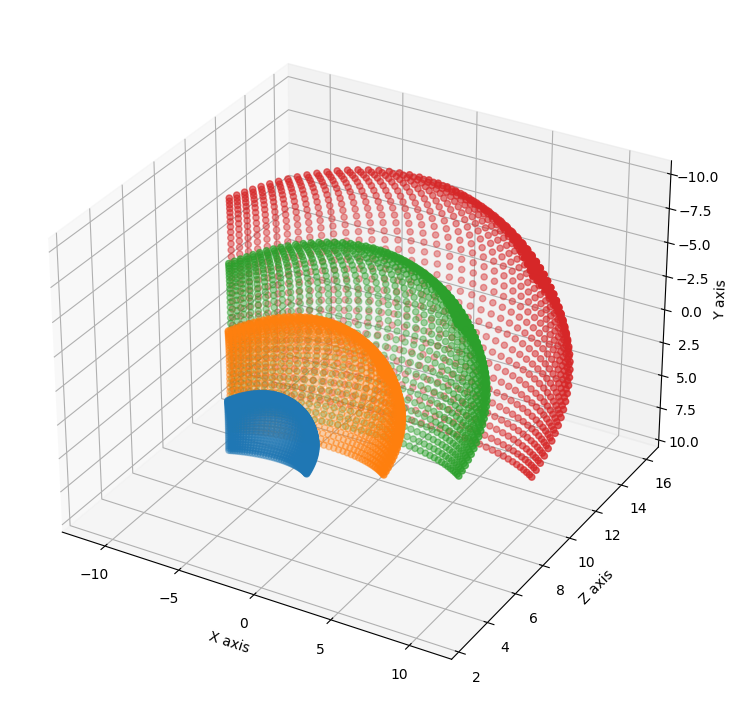

In [72]:
fig = plt.figure(figsize=(9, 9))

ax = fig.add_subplot(111, projection='3d')

for d in range(num_channel_depth):
    ax.scatter(frustum[0, ..., d], frustum[2, ..., d], frustum[1, ..., d])

# ax.set_xlim(0, 79)
# ax.set_ylim(0, 32)
# ax.set_zlim(16, -16)
ax.set_zlim(ax.get_zlim()[::-1])

ax.set_xlabel('X axis')
ax.set_ylabel('Z axis')
ax.set_zlabel('Y axis')

# 显示图形
plt.show()

In [73]:
R_ec, t_ec = image_data['extrinsic']
frustum_ego = R_ec @ frustum.reshape(3, -1) + t_ec[..., None]
frustum_ego = frustum_ego.reshape(3, -1, num_channel_depth)

In [74]:
# Rotaion.R_ec

In [75]:
# list(range(num_channel_depth))[::-1]

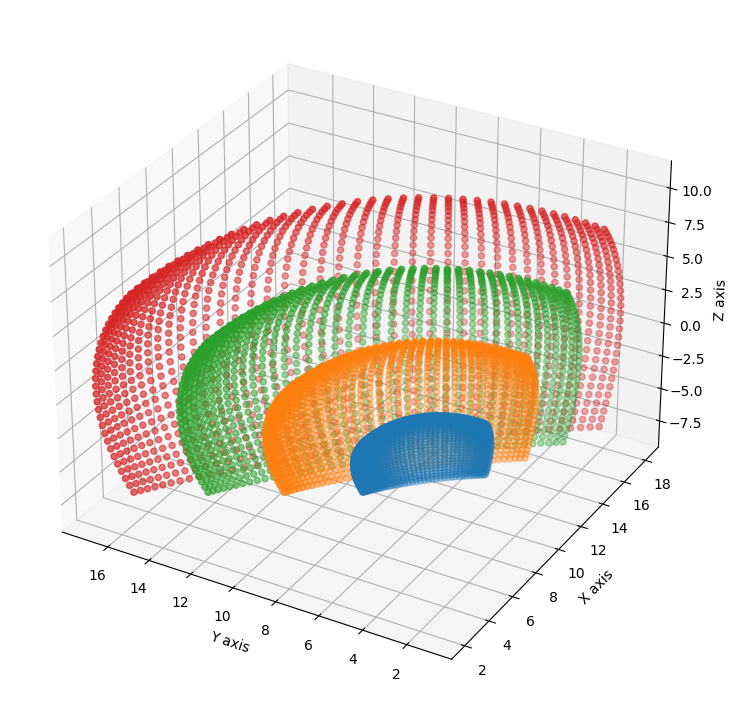

In [76]:
fig = plt.figure(figsize=(9, 9))

ax = fig.add_subplot(111, projection='3d')

for d in range(num_channel_depth):
    ax.scatter(frustum_ego[1, ..., d], frustum_ego[0, ..., d], frustum_ego[2, ..., d])

# ax.set_ylim(0, 32)
ax.set_xlim(ax.get_xlim()[::-1])
# ax.set_zlim(-10, 10)

ax.set_xlabel('Y axis')
ax.set_ylabel('X axis')
ax.set_zlabel('Z axis')

# 显示图形
plt.show()

In [77]:
vc.VCAMERA_PERSPECTIVE_FRONT_LEFT.extrinsic, image_data['extrinsic']

((array([[ 7.07106781e-01, -1.11022302e-16, -7.07106781e-01],
         [ 7.07106781e-01,  1.11022302e-16,  7.07106781e-01],
         [ 0.00000000e+00, -1.00000000e+00,  2.22044605e-16]]),
  (-1, 2, 1)),
 (array([[ 7.07106781e-01,  1.11022302e-16,  7.07106781e-01],
         [-7.07106781e-01,  1.11022302e-16,  7.07106781e-01],
         [ 0.00000000e+00, -1.00000000e+00,  2.22044605e-16]]),
  array([2.09698729, 1.06778281, 1.01063169])))

In [78]:
# TODO: think about defining depth as a distribution of ray length alone the ray

# Feature Transporting Matrix (FTM)
# u, v, d --> x, y, z --> resampled x, y, z
# for each u, v, d, we have a x, y, z
# for each x, y, z, we have a u, v, d
# decompose FTM into several matrices


FE = frustum_ego.reshape(P, *resolution[::-1], D).transpose(3, 1, 2, 0)
FE.shape

(4, 30, 40, 3)

In [79]:
from scipy.spatial.transform import Rotation
# define a voxel grid, in bev coordinate system
# TODO: convert ego to bev coordinates
# 'src_view_range': [back, front, right, left, bottom, up], # in ego system
voxel_grid = np.zeros((4, 320, 160))
Z, X, Y = voxel_grid.shape

voxel_range = np.array([
    [-2, 2],
    [36, -12],
    [12, -12]
])

fx = X / (voxel_range[1][1] - voxel_range[1][0])
fy = Y / (voxel_range[2][1] - voxel_range[2][0])
fz = Z / (voxel_range[0][1] - voxel_range[0][0])

cx = - voxel_range[1][0] * fx - 0.5
cy = - voxel_range[2][0] * fy - 0.5
cz = - voxel_range[0][0] * fz - 0.5

In [80]:
# MatrixVT / LSS, image depth to voxel grid

D, V, U = FE.shape[:3]

for d in range(D):
    for v in range(V):
        for u in range(U):
            x, y, z = FE[d, v, u]
            x = fx * x + cx
            y = fy * y + cy
            z = fz * z + cz
            x_, y_, z_ = round(x), round(y), round(z)
            if x_ >= 0 and x_ < X and y_ >= 0 and y_ < Y and z_ >= 0 and z_ < Z:
                voxel_grid[z_, x_, y_] = 1


In [81]:
zz, xx, yy = voxel_grid.nonzero()

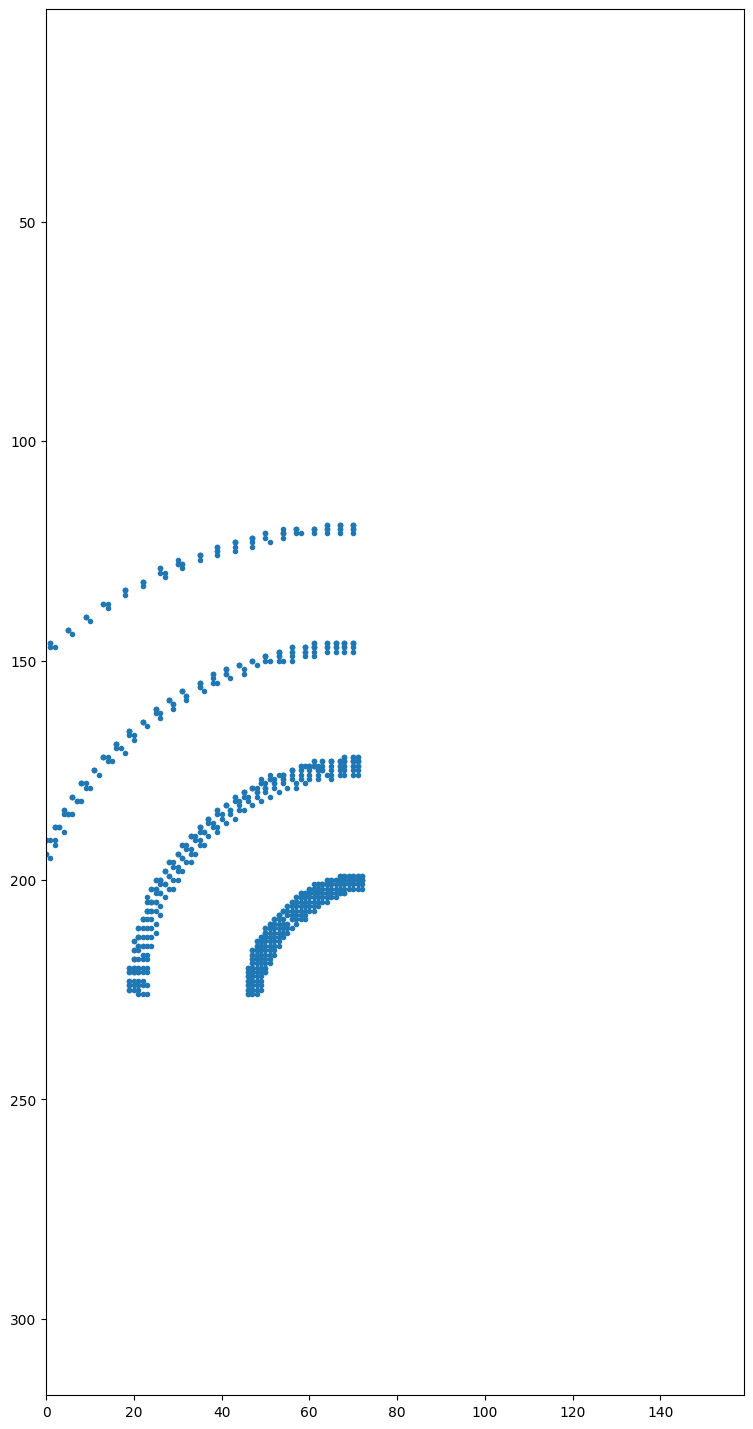

In [82]:
plt.figure(figsize=(9, 18))
plt.plot(yy, xx, '.')
plt.axis('equal')
plt.xlim(0, Y - 1)
plt.ylim(X - 1, 0)
plt.show()

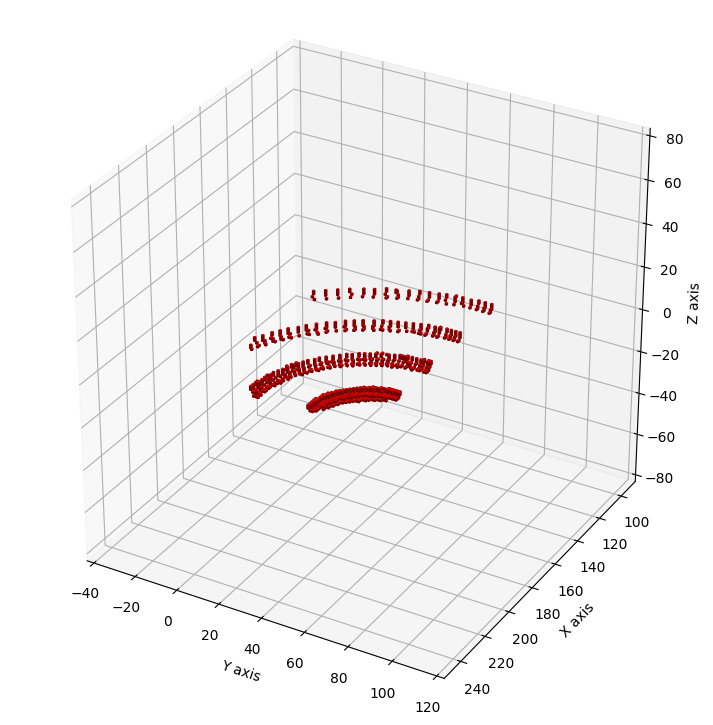

In [116]:
fig = plt.figure(figsize=(16, 9))

ax = fig.add_subplot(111, projection='3d')

# ax.scatter(yy, xx, zz)
ax.voxels(voxel_grid.transpose(2, 1, 0), facecolors='red')

ax.set_ylim(250, 90)
ax.set_xlim(0-40, 80+40)
ax.set_zlim(0-80, 4+76)

# ax.set_ylim(ax.get_ylim()[::-1])
ax.set_aspect('auto')
ax.set_ylabel('X axis')
ax.set_xlabel('Y axis')
ax.set_zlabel('Z axis')

# ax.axis('off')
ax.set_box_aspect([1, 1, 1])

# 显示图形
plt.show()

# FAST BEV (Voxel to Image Transform)

In [29]:
# gen Look-Up-Table

In [14]:
def get_voxel_points_in_ego(voxel_shape, voxel_range):
    # voxel_shape = (4, 320, 160)
    # voxel_range = [[-2, 2], [36, -12], [12, -12]]
    # output shape: (3, 4*320*160)
    # voxel_points = np.array([zz, xx, yy]).reshape(3, -1)
    Z, X, Y = voxel_shape

    fz = Z / (voxel_range[0][1] - voxel_range[0][0])
    fx = X / (voxel_range[1][1] - voxel_range[1][0])
    fy = Y / (voxel_range[2][1] - voxel_range[2][0])

    cz = - voxel_range[0][0] * fz - 0.5
    cx = - voxel_range[1][0] * fx - 0.5
    cy = - voxel_range[2][0] * fy - 0.5

    vzz, vxx, vyy = np.meshgrid(np.arange(Z), np.arange(X), np.arange(Y), indexing='ij')

    zz = (vzz - cz) / fz
    xx = (vxx - cx) / fx
    yy = (vyy - cy) / fy

    voxel_points = np.array([xx, yy, zz]).reshape(3, -1)

    return voxel_points

# in shape of Z, X, Y (EGO)
voxel_shape = (12, 320, 160)
# voxel_shape = (4, 48, 24)
# in ego system
voxel_range = np.array([
    [-2.5, 3.5],
    [36, -12],
    [12, -12]
])

voxel_points = get_voxel_points_in_ego(voxel_shape, voxel_range)


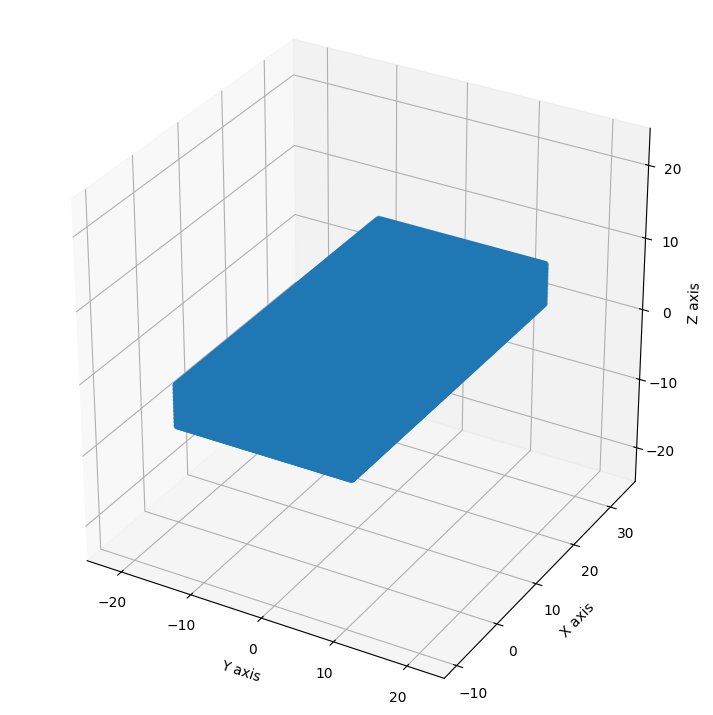

In [15]:
fig = plt.figure(figsize=(16, 9))

ax = fig.add_subplot(111, projection='3d')

# ax.scatter(yy, xx, zz)
ax.scatter(voxel_points[1], voxel_points[0], voxel_points[2])
# ax.voxels(voxel_grid.transpose(2, 1, 0), facecolors='red')

ax.set_ylim(-12, 36)
ax.set_xlim(-24, 24)
ax.set_zlim(-24, 24)

# ax.set_ylim(ax.get_ylim()[::-1])
ax.set_aspect('auto')
ax.set_ylabel('X axis')
ax.set_xlabel('Y axis')
ax.set_zlabel('Z axis')

# ax.axis('off')
ax.set_box_aspect([1, 1, 1])

# 显示图形
plt.show()

In [243]:
voxel_points.shape

(3, 204800)

In [119]:
# keys

In [55]:
def get_voxel_points_in_ego(voxel_shape, voxel_range):
    # voxel_shape = (4, 320, 160)
    # voxel_range = [[-2, 2], [36, -12], [12, -12]]
    # output shape: (3, 4*320*160)
    # voxel_points = np.array([zz, xx, yy]).reshape(3, -1)
    Z, X, Y = voxel_shape

    fz = Z / (voxel_range[0][1] - voxel_range[0][0])
    fx = X / (voxel_range[1][1] - voxel_range[1][0])
    fy = Y / (voxel_range[2][1] - voxel_range[2][0])

    cz = - voxel_range[0][0] * fz - 0.5
    cx = - voxel_range[1][0] * fx - 0.5
    cy = - voxel_range[2][0] * fy - 0.5

    vzz, vxx, vyy = np.meshgrid(np.arange(Z), np.arange(X), np.arange(Y), indexing='ij')

    zz = (vzz - cz) / fz
    xx = (vxx - cx) / fx
    yy = (vyy - cy) / fy

    voxel_points = np.array([xx, yy, zz]).reshape(3, -1)

    return voxel_points


default_camera_feature_config = dict(
    ray_distance_num_channel=64,
    ray_distance_start=0.25,
    ray_distance_step=0.25,
    feature_downscale=8,
)


class VoxelLookUpTableGenerator:
    '''
    Generate LUTS from <x,y,z> to <img_id,u,v,d>.
    
    '''
    def __init__(
            self,
            voxel_feature_config=dict(
                voxel_shape=(6, 320, 160),  # Z, X, Y in ego system
                voxel_range=([-0.5, 2.5], [36, -12], [12, -12]),
                ego_distance_max=40,
                ego_distance_step=5
            ),
            camera_feature_configs=dict(
                VCAMERA_FISHEYE_FRONT=default_camera_feature_config,
                VCAMERA_PERSPECTIVE_FRONT_LEFT=default_camera_feature_config,
                VCAMERA_PERSPECTIVE_BACK_LEFT=default_camera_feature_config,
                VCAMERA_FISHEYE_LEFT=default_camera_feature_config,
                VCAMERA_PERSPECTIVE_BACK=default_camera_feature_config,
                VCAMERA_FISHEYE_BACK=default_camera_feature_config,
                VCAMERA_PERSPECTIVE_FRONT_RIGHT=default_camera_feature_config,
                VCAMERA_PERSPECTIVE_BACK_RIGHT=default_camera_feature_config,
                VCAMERA_FISHEYE_RIGHT=default_camera_feature_config,
                VCAMERA_PERSPECTIVE_FRONT=default_camera_feature_config
            )
        ):
        '''
        inputs:
        - voxel_feature_config: dict
            - voxel_shape: (Z, X, Y) in ego system
            - voxel_range: ([zmin, zmax], [xmin, xmax], [ymin, ymax]) in ego system, in meters
            - ego_distance_max: maximum ego distance in meters
            - ego_distance_step: step size of ego distance
        - camera_feature_configs: dict
            - <cam_id>: dict
                - ray_distance_num_channel: number of channels in ray distance
                - ray_distance_start: start distance of ray in meters
                - ray_distance_step: step size of ray distance
                - feature_downscale: downscale of feature map
            
        '''
        self.voxel_feature_config = voxel_feature_config
        self.camera_feature_configs = camera_feature_configs
        self.voxel_shape = self.voxel_feature_config['voxel_shape']
        self.voxel_range = np.float32(self.voxel_feature_config['voxel_range'])
        # gen voxel_ego_points, in shape of (3, 4*320*160) <3, Z*X*Y>
        self.voxel_points = get_voxel_points_in_ego(self.voxel_shape, self.voxel_range)
    
    def generate(self, camera_images, seed=None):
        ego_distance_max = self.voxel_feature_config['ego_distance_max']
        ego_distance_step = self.voxel_feature_config['ego_distance_step']
        distances_ego = np.linalg.norm(self.voxel_points, axis=0)
        distance_bins = np.arange(0, ego_distance_max + ego_distance_step, ego_distance_step)

        LUT = {}

        # loop in cameras, gen LUTS from <x,y,z> to <img_id,u,v,d>
        keys = []
        density_maps = []
        for key in camera_images:
            keys.append(key)
            image_data = camera_images[key].data
            # gen camera points, in shape of (3, Z*X*Y)
            R_ec, t_ec = image_data['extrinsic']
            camera_points = R_ec.T @ (self.voxel_points - t_ec[..., None])
            # camera feature settings
            downscale = self.camera_feature_configs[key]['feature_downscale']
            resolution = np.array(image_data['img'].shape[:2][::-1]) // downscale
            intrinsics = np.array(image_data['intrinsic'])
            intrinsics[:4] /= downscale
            camera_class = getattr(vc, image_data['cam_type'])
            camera = camera_class(
                resolution,
                image_data['extrinsic'],
                intrinsics,
            )
            uu_float, vv_float = camera.project_points_from_camera_to_image(camera_points) # in shape of Z*X*Y
            # ray distance settings
            ray_distance_start = self.camera_feature_configs[key]['ray_distance_start']
            ray_distance_step = self.camera_feature_configs[key]['ray_distance_step']
            ray_distance_num_channel = self.camera_feature_configs[key]['ray_distance_num_channel']
            distances = np.linalg.norm(camera_points, axis=0) # Z*X*Y
            dd_float = (distances - ray_distance_start) / ray_distance_step
            # rasterize, Z*X*Y, 4*320*160
            uu = np.round(uu_float).astype(int)  
            vv = np.round(vv_float).astype(int)
            dd = np.round(dd_float).astype(int)
            dd[dd < ray_distance_num_channel] = ray_distance_num_channel - 1
            # get valid maps, Z*X*Y, 4*320*160
            valid_map = (uu >= 0) * (uu < resolution[0]) * (vv >= 0) * (vv < resolution[1]) * (camera_points[2] > 0)
            uv_mask = cv2.resize(image_data['ego_mask'], resolution)
            valid_map *= uv_mask[vv * valid_map, uu * valid_map].astype(bool)
            uu_float[~valid_map] = -1
            vv_float[~valid_map] = -1
            dd_float[~valid_map] = -1
            uu[~valid_map] = -1
            vv[~valid_map] = -1
            dd[~valid_map] = -1
            # allocate LUTS
            LUT[key] = dict(uu=uu, vv=vv, dd=dd, valid_map=valid_map)
            # gen voxel ray density for each camera, in shape of Z*X*Y
            density_map = np.zeros_like(distances_ego)
            for dist_ind in range(len(distance_bins) - 1):
                valid_dist = (distances_ego > distance_bins[dist_ind]) & (distances_ego <= distance_bins[dist_ind + 1])
                valid_u = uu_float[valid_dist * valid_map]
                valid_v = vv_float[valid_dist * valid_map]
                if len(valid_u) > 0 and len(valid_v) > 0:
                    density_map[valid_dist * valid_map] = (valid_u.max() - valid_u.min()) * (valid_v.max() - valid_v.min())
            density_maps.append(density_map)
            
        # normalize density
        density_maps = np.stack(density_maps)
        density_maps_norm = density_maps / (density_maps.sum(axis=0, keepdims=True) + 1e-5)
        
        # generate random sampled LUT from x,y,z to <cam_id> according to density
        rng = np.random.default_rng(seed)
        random_map = rng.random(distances_ego.shape)
        for key_ind, key in enumerate(keys):
            acc_density_min = density_maps_norm[:key_ind].sum(axis=0)
            acc_density_max = density_maps_norm[:key_ind + 1].sum(axis=0)
            LUT[key]['valid_map_sampled'] = (random_map >= acc_density_min) * (random_map < acc_density_max)
            LUT[key]['norm_density_map'] = density_maps_norm[key_ind]
        
        return LUT
        

In [85]:
voxel_feature_config = dict(
    voxel_shape=(6, 320, 160),  # Z, X, Y in ego system
    # voxel_shape=(8, 192, 96),  # Z, X, Y in ego system
    # voxel_range=([-5, 7], [36, -12], [12, -12]),
    voxel_range=([-0.5, 2.5], [36, -12], [12, -12]),
    ego_distance_max=40,
    ego_distance_step=2
)
general_camera_feature_config = dict(
    ray_distance_num_channel=64,
    ray_distance_start=0.25,
    ray_distance_step=0.25,
    feature_downscale=1,
)

fisheye_camera_feature_config = dict(
    ray_distance_num_channel=64,
    ray_distance_start=0.25,
    ray_distance_step=0.25,
    feature_downscale=2,
)

camera_feature_configs = dict(
    VCAMERA_FISHEYE_FRONT=fisheye_camera_feature_config,
    VCAMERA_PERSPECTIVE_FRONT_LEFT=general_camera_feature_config,
    VCAMERA_PERSPECTIVE_BACK_LEFT=general_camera_feature_config,
    VCAMERA_FISHEYE_LEFT=fisheye_camera_feature_config,
    VCAMERA_PERSPECTIVE_BACK=general_camera_feature_config,
    VCAMERA_FISHEYE_BACK=fisheye_camera_feature_config,
    VCAMERA_PERSPECTIVE_FRONT_RIGHT=general_camera_feature_config,
    VCAMERA_PERSPECTIVE_BACK_RIGHT=general_camera_feature_config,
    VCAMERA_FISHEYE_RIGHT=fisheye_camera_feature_config,
    VCAMERA_PERSPECTIVE_FRONT=general_camera_feature_config
)


lut_gen = VoxelLookUpTableGenerator(
    voxel_feature_config=voxel_feature_config,
    camera_feature_configs=camera_feature_configs
)


LUT = lut_gen.generate(camera_images)

In [92]:
LUT['VCAMERA_FISHEYE_FRONT'].keys()
# LUT['random_img_ind_map'].shape, LUT['valid_maps'].shape, LUT['uus'].shape

dict_keys(['uu', 'vv', 'dd', 'valid_map', 'valid_map_sampled', 'norm_density_map'])

In [87]:
# GIVE A TRY !!!
# gen fake camera features

voxel_feature = np.zeros((3, *lut_gen.voxel_shape)).reshape(3, -1)

for key in camera_images:
    # if key not in [
    #     'VCAMERA_FISHEYE_LEFT',
    #     'VCAMERA_FISHEYE_BACK'
    # ]:
    #     continue
    # print(key_ind, key)
    img_arr = camera_images[key].data['img']
    resolution = np.array(img_arr.shape[:2][::-1]) // lut_gen.camera_feature_configs[key]['feature_downscale']
    feature = cv2.resize(img_arr, resolution).transpose(2, 0, 1)
    # print(feature.shape)
    # plt.imshow(feature[1]); plt.show()
    valid_ind_map = LUT[key]['valid_map']
    # valid_ind_map = LUT[key]['valid_map_sampled']
    weight_map = LUT[key]['norm_density_map']

    # voxel_feature[:, valid_ind_map] = weight_map[
    #     LUT[key]['vv'][valid_ind_map], LUT[key]['uu'][valid_ind_map]
    # ]

    # print(weight_map[:, valid_ind_map].shape)

    voxel_feature[:, valid_ind_map] += weight_map[valid_ind_map] * feature[
        :, LUT[key]['vv'][valid_ind_map], LUT[key]['uu'][valid_ind_map]
    ] / 255

    # voxel_feature[:, valid_ind_map] = feature[
    #     :, LUT[key]['vv'][valid_ind_map], LUT[key]['uu'][valid_ind_map]
    # ] / 255

    # plt.figure(figsize=(9, 16))
    # plt.title(key)
    # plt.imshow(valid_ind_map.reshape(*lut_gen.voxel_shape)[0])
    # plt.imshow((voxel_feature[1] * valid_ind_map).reshape(*lut_gen.voxel_shape)[0])
    # plt.show()
    # break

voxel_feature.shape

(3, 307200)

In [88]:
# voxel_feature /= 255

In [89]:
# voxel_feature[1].shape, lut_gen.voxel_shape, 8 * 192 * 96

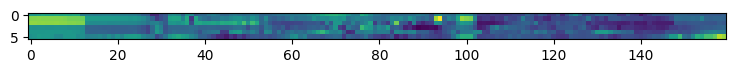

In [90]:
plt.figure(figsize=(9, 16))
# plt.imshow(voxel_feature[1].reshape(*lut_gen.voxel_shape)[0])
# plt.imshow(voxel_feature[1].reshape(*lut_gen.voxel_shape)[:, 100:, 0])
plt.imshow(voxel_feature[1].reshape(*lut_gen.voxel_shape)[:, 160, :])
plt.show()
# plt.figure(figsize=(9, 16)); plt.imshow(voxel_feature[1].reshape(*lut_gen.voxel_shape)[3]); plt.show()

# fig = plt.figure()
# ax = fig.add_subplot(111, projection='3d')

# # ax.scatter(yy, xx, zz)
# ax.voxels(voxel_feature[1].reshape(*lut_gen.voxel_shape).transpose(2, 1, 0), facecolors='red')

# ax.set_ylim(250, 90)
# ax.set_xlim(0-40, 80+40)
# ax.set_zlim(0-80, 4+76)

# # ax.set_ylim(ax.get_ylim()[::-1])
# ax.set_aspect('auto')
# ax.set_ylabel('X axis')
# ax.set_xlabel('Y axis')
# ax.set_zlabel('Z axis')

# # ax.axis('off')
# ax.set_box_aspect([1, 1, 1])

# # 显示图形
# plt.show()

In [244]:
# get all camera features

keys = []
valid_maps = []
weight_maps = []
uus = []
vvs = []
dds = []

uus_float = []
vvs_float = []

distances_ego = np.linalg.norm(voxel_points, axis=0)

for key in camera_images:
    keys.append(key)
    image_data = camera_images[key].data
    R_ec, t_ec = image_data['extrinsic']
    camera_points = R_ec.T @ (voxel_points - t_ec[..., None])
    # print(camera_points.shape)

    distances = np.linalg.norm(camera_points, axis=0)

    ray_distance_start = 0.25
    ray_distance_step = 0.25
    num_channel_depth = 64
    # distance_bins = np.arange(ray_distance_start, ray_distance_start + ray_distance_step * num_channel_depth, ray_distance_step)

    downscale = 32
    resolution = np.array(image_data['img'].shape[:2][::-1])
    intrinsics = np.array(image_data['intrinsic'])

    resolution = resolution // downscale
    intrinsics[:4] /= downscale

    camera_class = getattr(vc, image_data['cam_type'])
    camera = camera_class(
        resolution,
        image_data['extrinsic'],
        intrinsics,
    )

    uu, vv = camera.project_points_from_camera_to_image(camera_points)
    # print(uu.shape, vv.shape)
    uu_float, vv_float = camera.project_points_from_camera_to_image(camera_points)
    dd_float = (distances - ray_distance_start) / ray_distance_step

    uu = np.round(uu_float).astype(int)  
    vv = np.round(vv_float).astype(int)
    dd = np.round(dd_float).astype(int)
    
    dd[dd < num_channel_depth] = num_channel_depth - 1

    valid_map = (uu >= 0) * (uu < resolution[0]) * (vv >= 0) * (vv < resolution[1]) * (camera_points[2] > 0)
    uv_mask = cv2.resize(image_data['ego_mask'], resolution)

    valid_map *= uv_mask[vv * valid_map, uu * valid_map].astype(bool)
    
    uu_float[~valid_map] = -1
    vv_float[~valid_map] = -1
    dd_float[~valid_map] = -1

    uu[~valid_map] = -1
    vv[~valid_map] = -1
    dd[~valid_map] = -1

    weight_map = valid_map * (1 - np.linalg.norm([uu_float - uu, vv_float - vv], axis=0))
    # weight_map = valid_map * (1 - np.linalg.norm([uu_float - uu], axis=0))
    # weight_map = valid_map * (1 - np.linalg.norm([vv_float - vv], axis=0))
    weight_maps.append(weight_map)

    valid_maps.append(valid_map)
    uus.append(uu)
    vvs.append(vv)
    dds.append(dd)

    uus_float.append(uu_float)
    vvs_float.append(vv_float)

    # break
    # frustum_ego = R_ec @ frustum.reshape(3, -1) + t_ec[..., None]
    # frustum_ego = frustum_ego.reshape(3, -1, num_channel_depth)

# weight_maps = np.stack(weight_maps)
valid_maps = np.stack(valid_maps)
uus = np.stack(uus)
vvs = np.stack(vvs)
dds = np.stack(dds)

uus_float = np.stack(uus_float)
vvs_float = np.stack(vvs_float)

In [245]:
keys

['VCAMERA_FISHEYE_FRONT',
 'VCAMERA_PERSPECTIVE_FRONT_LEFT',
 'VCAMERA_PERSPECTIVE_BACK_LEFT',
 'VCAMERA_FISHEYE_LEFT',
 'VCAMERA_PERSPECTIVE_BACK',
 'VCAMERA_FISHEYE_BACK',
 'VCAMERA_PERSPECTIVE_FRONT_RIGHT',
 'VCAMERA_PERSPECTIVE_BACK_RIGHT',
 'VCAMERA_FISHEYE_RIGHT',
 'VCAMERA_PERSPECTIVE_FRONT']

In [246]:
# 计算在相同距离d的情况下，u,v的计数（或者面积）的大小作为其光子密度的函数

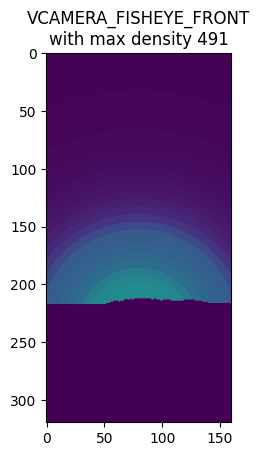

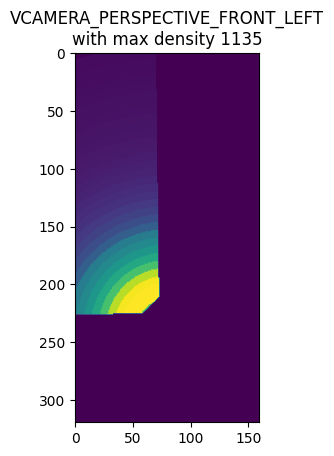

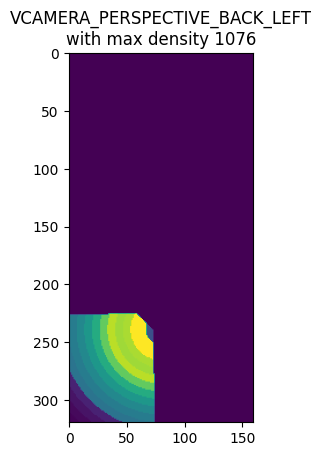

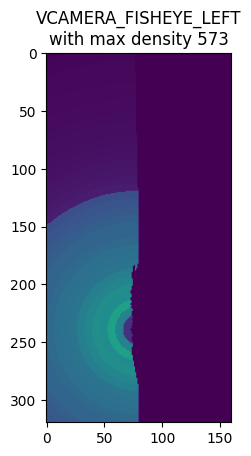

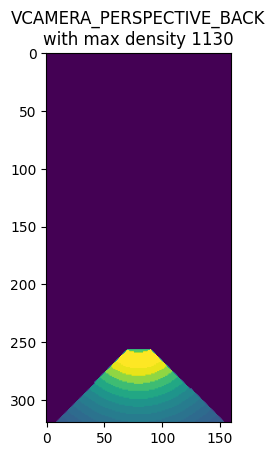

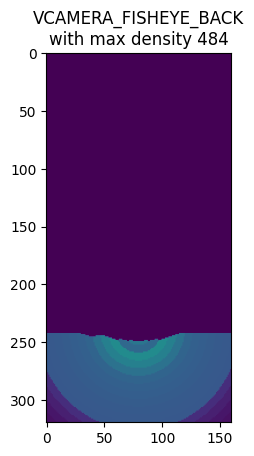

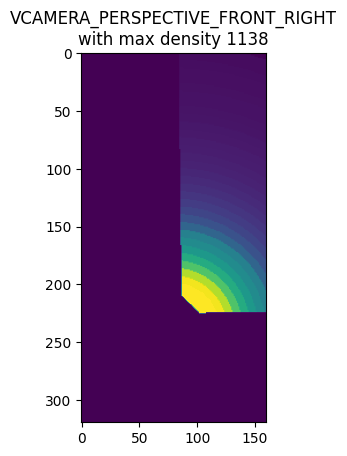

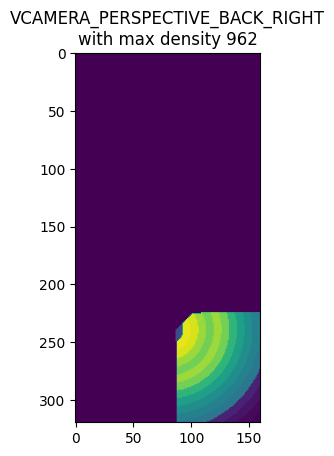

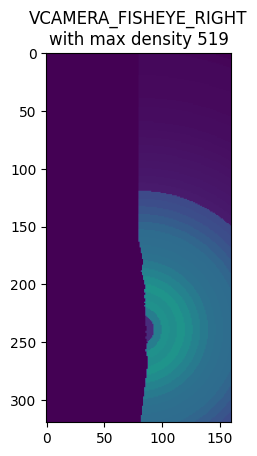

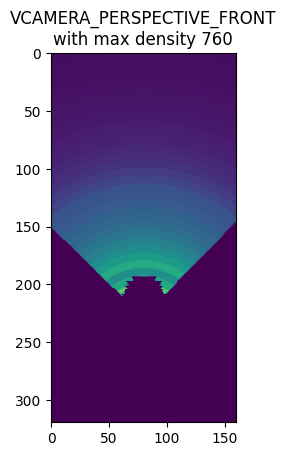

In [248]:
MAX_DISTANCE = 40
DISTANCE_STEP = 1
distance_bins = np.arange(0, MAX_DISTANCE + DISTANCE_STEP, DISTANCE_STEP)

density_maps = []
for key_ind, key in enumerate(keys):
    density_map = np.zeros_like(distances_ego)
    for dist_ind in range(len(distance_bins) - 1):
        valid_dist = (distances_ego > distance_bins[dist_ind]) & (distances_ego <= distance_bins[dist_ind + 1])
        valid_u = uus_float[key_ind][valid_dist * valid_maps[key_ind]]
        valid_v = vvs_float[key_ind][valid_dist * valid_maps[key_ind]]
        if len(valid_u) > 0 and len(valid_v) > 0:
            density_map[valid_dist * valid_maps[key_ind]] = (valid_u.max() - valid_u.min()) * (valid_v.max() - valid_v.min())
    density_maps.append(density_map)
    plt.imshow(density_map.reshape(*voxel_shape)[1], vmin=0, vmax=1000)
    plt.title(key + '\nwith max density {:.0f}'.format(density_map.max()))
    plt.show()
    # break
density_maps = np.stack(density_maps)

In [249]:
norm_density_maps = density_maps / (density_maps.sum(axis=0, keepdims=True) + 1e-3)

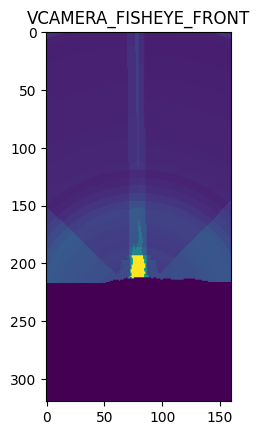

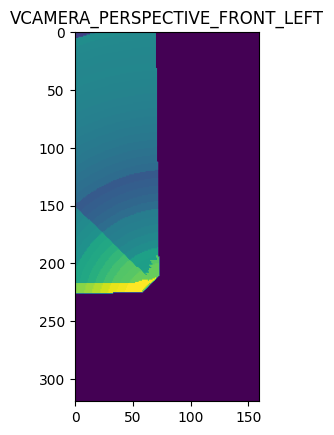

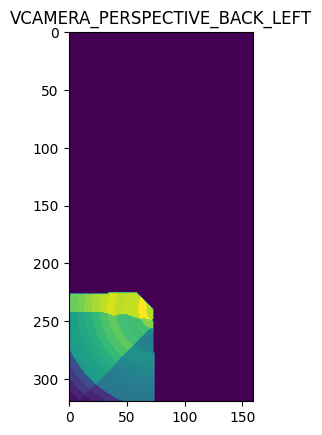

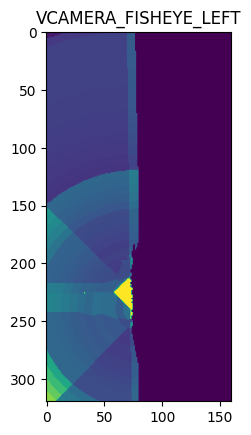

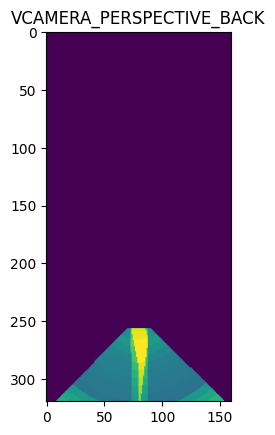

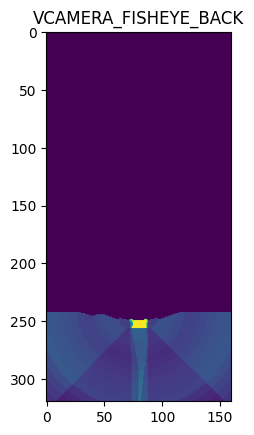

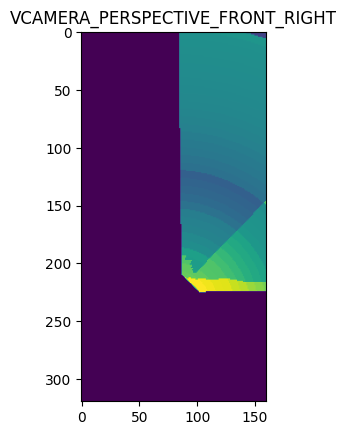

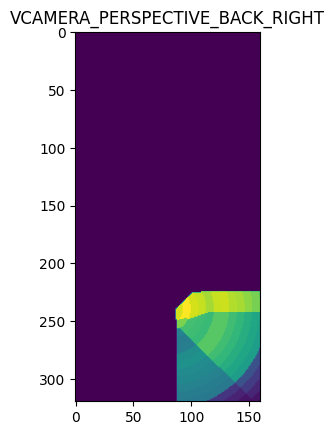

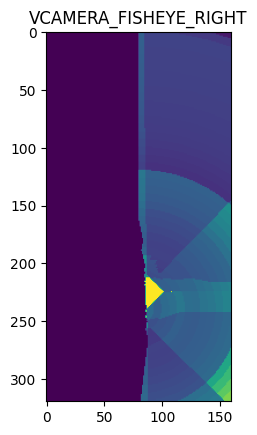

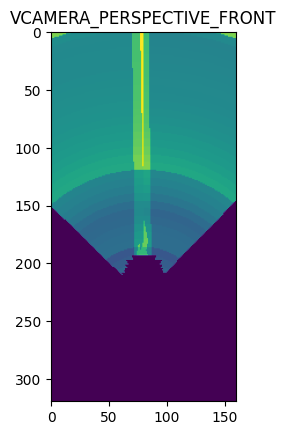

In [255]:
# plt.imshow(norm_density_maps[:2].sum(axis=0).reshape(*voxel_shape)[0])
# plt.imshow(norm_density_maps[:].sum(axis=0).reshape(*voxel_shape)[0])

for key_ind, key in enumerate(keys):
    plt.imshow(norm_density_maps[key_ind].reshape(*voxel_shape)[1])
    plt.title(key)
    plt.show()

In [134]:
rng = np.random.default_rng()
random_map = rng.random(norm_density_maps[0].shape)
# random_map = np.random.uniform(size=voxel_shape)

img_ind_maps = []

for key_ind, key in enumerate(keys):
    acc_density_min = norm_density_maps[:key_ind].sum(axis=0)
    acc_density_max = norm_density_maps[:key_ind + 1].sum(axis=0)
    valid_sample = (random_map > acc_density_min) * (random_map <= acc_density_max)
    ind_sample = (key_ind + 1) * valid_sample
    # ind_sample[~valid_sample] = -1
    img_ind_maps.append(ind_sample)

random_img_ind_map = np.array(img_ind_maps).sum(axis=0) - 1  # Z*X*Y, 4*320*160
# plt.imshow((random_map < norm_density_maps[9]).reshape(*voxel_shape)[1])

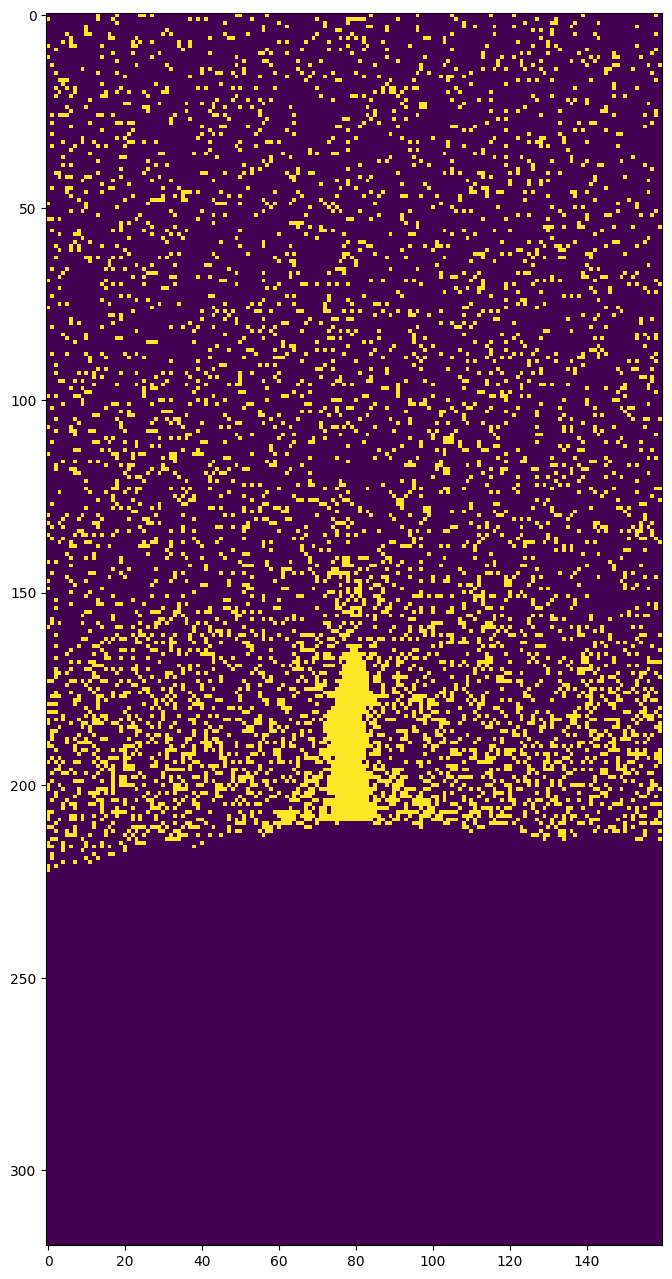

In [135]:
plt.figure(figsize=(9, 16)); plt.imshow((random_img_ind_map == 0).reshape(*voxel_shape)[0]); plt.show()
# plt.figure(figsize=(9, 16)); plt.imshow((random_img_ind_map == 1).reshape(*voxel_shape)[0]); plt.show()
# plt.figure(figsize=(9, 16)); plt.imshow((random_img_ind_map == 2).reshape(*voxel_shape)[0]); plt.show()
# plt.imshow(np.array(camera_ind_maps).sum(axis=0).reshape(*voxel_shape)[1])

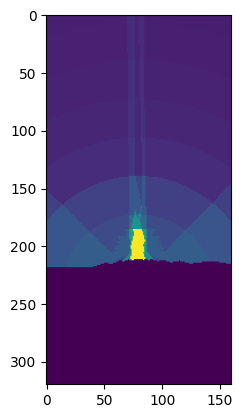

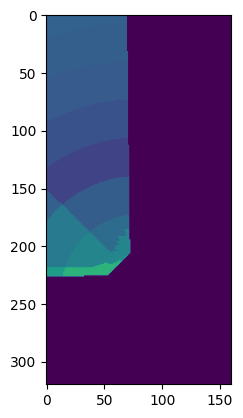

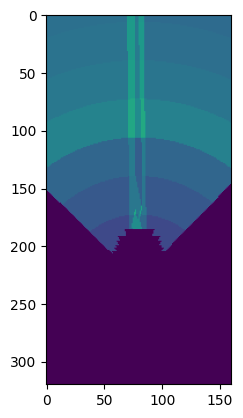

In [42]:
plt.imshow(norm_density_maps[0].reshape(*voxel_shape)[1], vmin=0, vmax=1); plt.show()
plt.imshow(norm_density_maps[1].reshape(*voxel_shape)[1], vmin=0, vmax=1); plt.show()
plt.imshow(norm_density_maps[9].reshape(*voxel_shape)[1], vmin=0, vmax=1); plt.show()

In [37]:

# cared_keys = [
#     'VCAMERA_FISHEYE_FRONT',
#     'VCAMERA_PERSPECTIVE_FRONT'
# ]

# # for key, weight_map in zip(keys, weight_maps):
# for key in cared_keys:
#     img_id = keys.index(key)
#     print(img_id)
#     ww = weight_maps[img_id].reshape(*voxel_shape)
#     print(ww.min(), ww.max())
#     plt.figure(figsize=(9, 16))
#     # plt.imshow(ww[0])
#     # plt.imshow(vvs[img_id].reshape(*voxel_shape)[2] * uus[img_id].reshape(*voxel_shape)[2])
#     plt.imshow(dds[img_id].reshape(*voxel_shape)[0])
#     # plt.imshow(ww[:3].transpose(1, 2, 0))
#     plt.title(key)
#     plt.show()
#     # break
# # plt.imshow(- dd.reshape(*voxel_shape)[1])

In [149]:
# lut = np.choose(random_map.reshape(-1) > 0.5, [weight_maps[0], weight_maps[9]])
# plt.figure(figsize=(9, 16))
# plt.imshow(lut.reshape(*voxel_shape)[2])

# plt.imshow(weight_maps[0].reshape(*voxel_shape)[0] - weight_maps[9].reshape(*voxel_shape)[0])

In [150]:
# cross_map_09 = (valid_maps[0] * valid_maps[9]).reshape(*voxel_shape)
# plt.imshow(cross_map_09[0])

# cc = (weight_maps[0] + weight_maps[9]).reshape(*voxel_shape)
# plt.imshow(cc[0])

# random_map = np.random.uniform(size=voxel_shape)

rng = np.random.default_rng()

In [151]:
rng.random()

0.35316017097711394

In [152]:
# random choose img_id according to img_weights
# 根据权重随机选择img_id

# np.random.choice([0, 9], p)

# samples_0 = (random_map > 0.5) * weight_maps[0].reshape(*voxel_shape)
# samples_9 = (random_map <= 0.5) * weight_maps[9].reshape(*voxel_shape)

# plt.figure(figsize=(9, 16))
# # plt.imshow(samples_0[0] > 0.5)
# plt.imshow(samples_9[0] > 0.5)

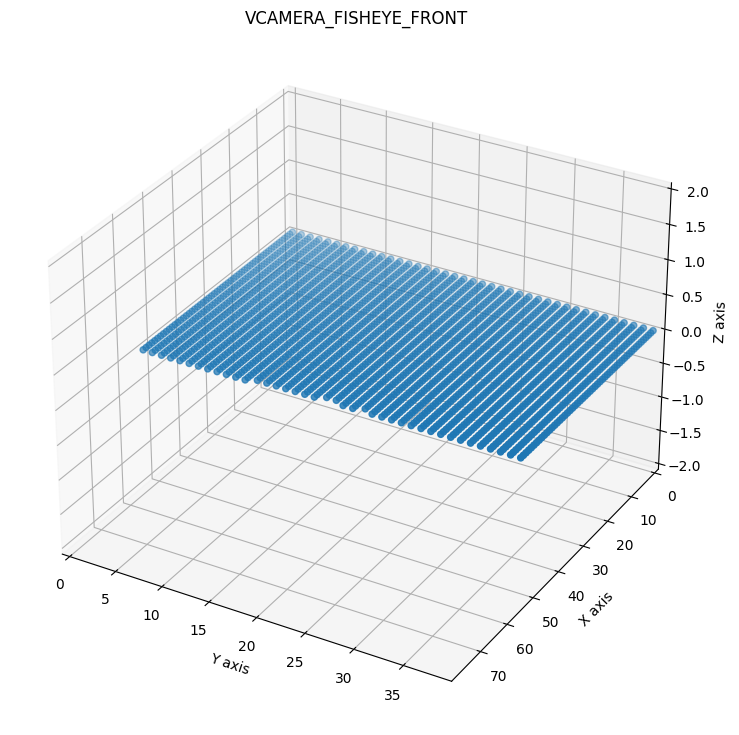

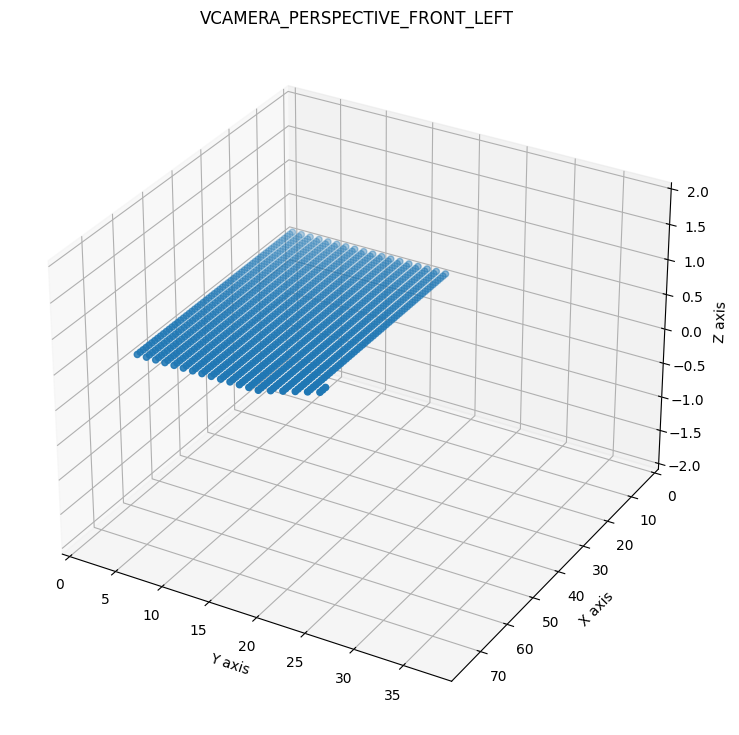

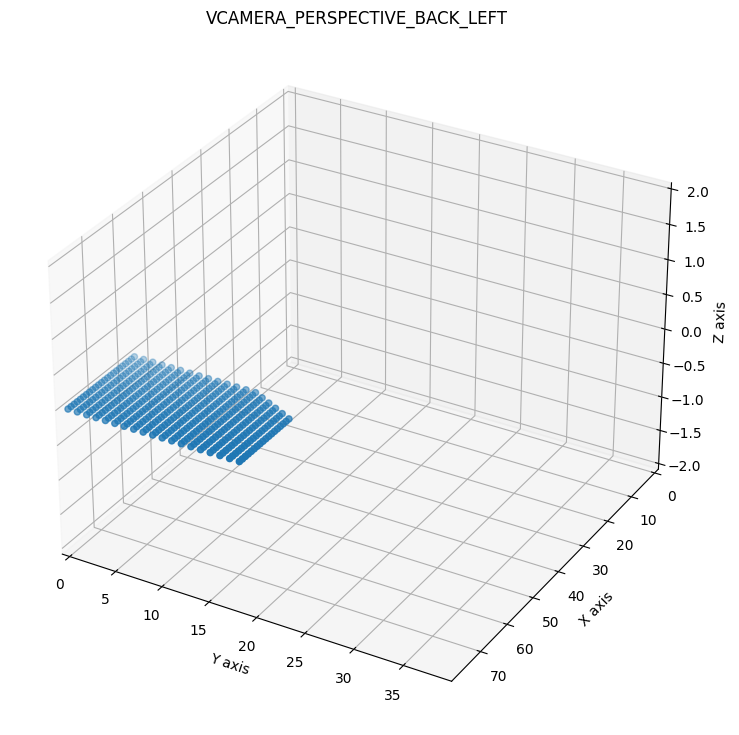

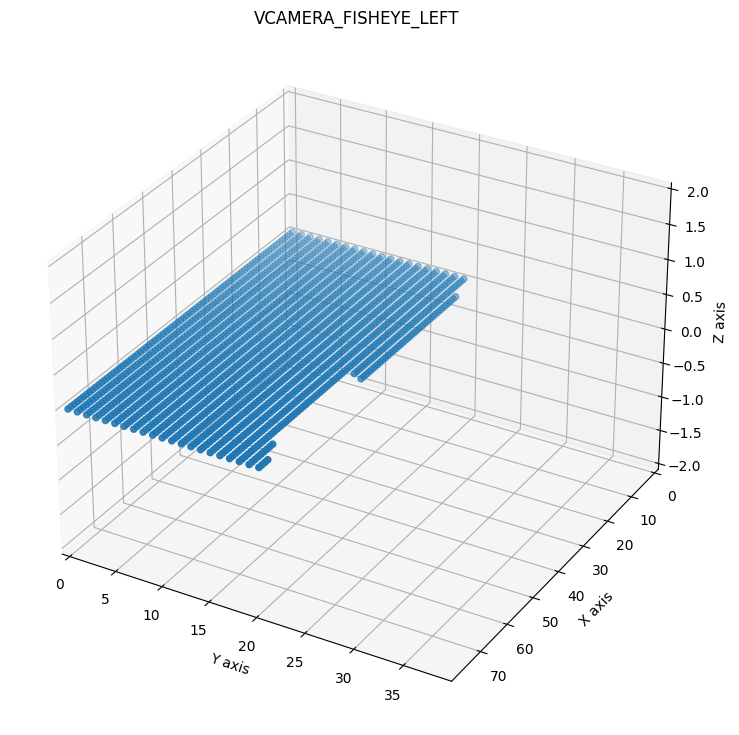

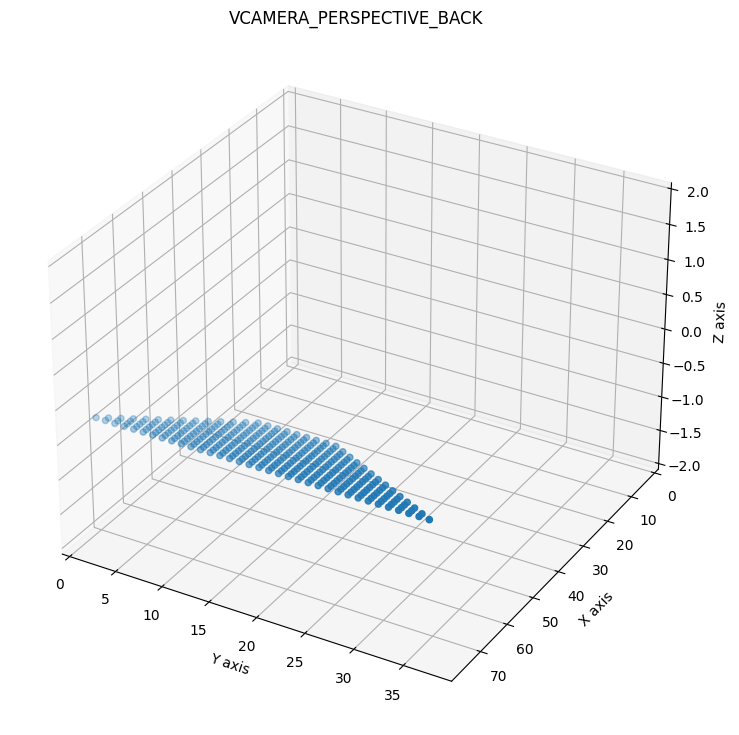

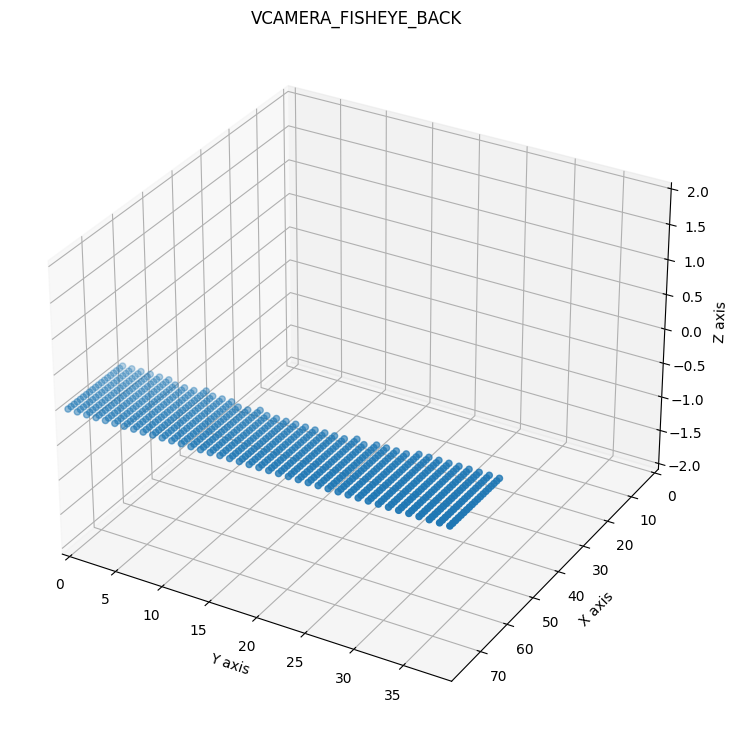

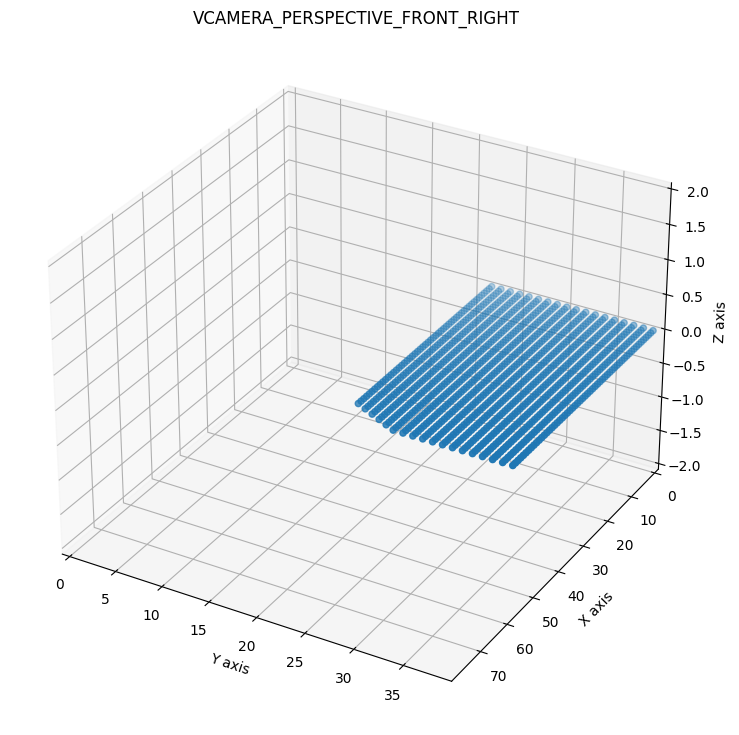

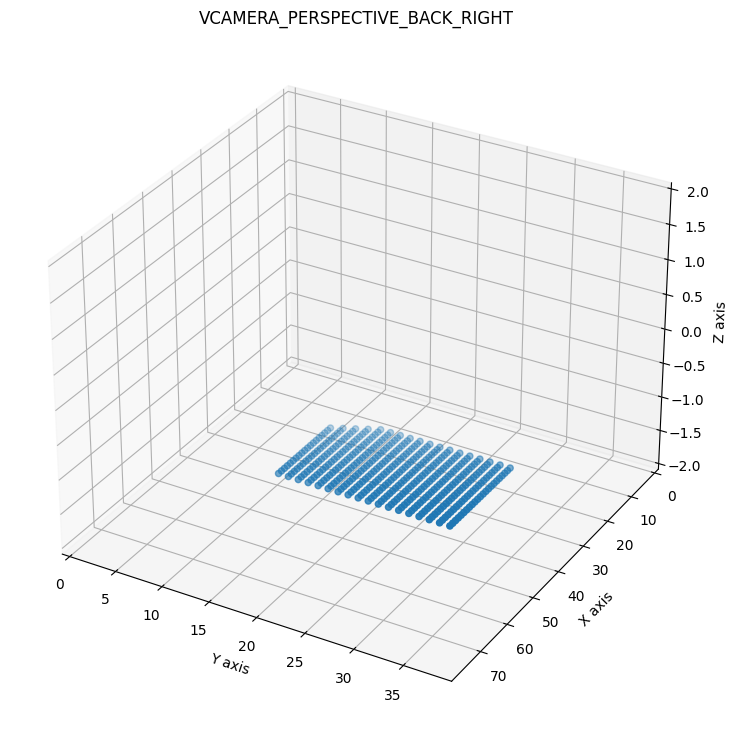

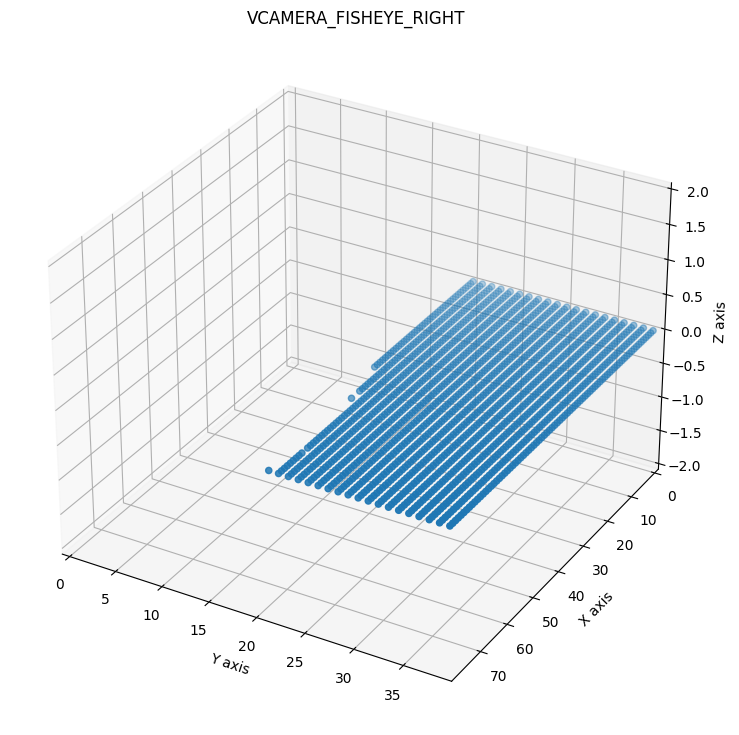

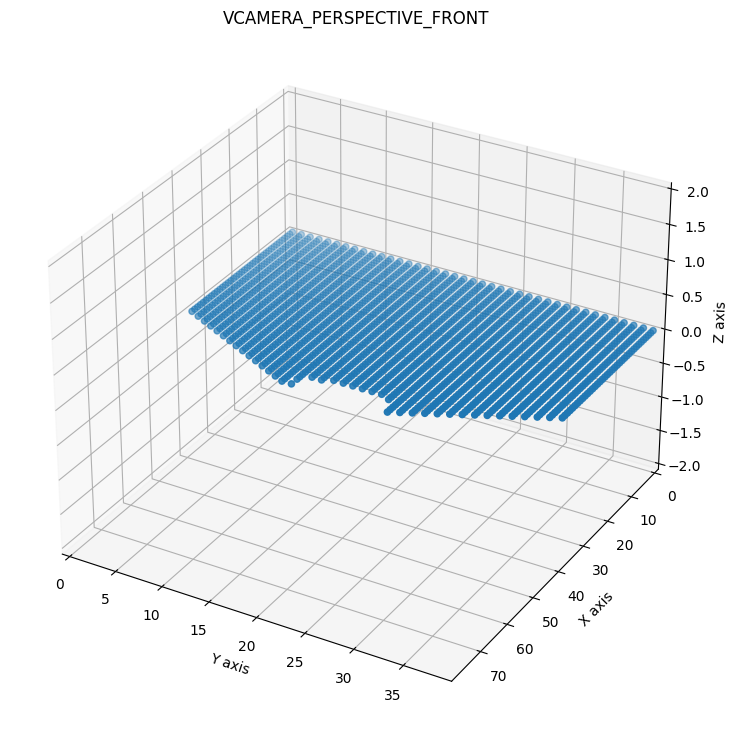

In [107]:
# fig = plt.figure(figsize=(16, 9))
# ax = fig.add_subplot(111, projection='3d')

# for img_id in range(valid_maps.shape[0]):
#     valid_map = valid_maps[img_id].reshape(*voxel_shape)[1:2, ::4, ::4]
#     zz, xx, yy = valid_map.nonzero()

#     fig = plt.figure(figsize=(16, 9))
#     ax = fig.add_subplot(111, projection='3d')
#     ax.scatter(yy, xx, zz)

#     ax.set_xlim(0, 39)
#     ax.set_ylim(0, 79)
#     ax.set_zlim(-2, 2)

#     ax.set_ylim(ax.get_ylim()[::-1])

#     ax.set_xlabel('Y axis')
#     ax.set_ylabel('X axis')
#     ax.set_zlabel('Z axis')

#     ax.set_title(keys[img_id])

#     # 显示图形
#     plt.show()

- 用好valid_map，尤其是要获取交叉视野，这个用于不同图片的匹配训练
- 实现交叉视野的分配策略，构造整体的LUT，十分重要， 最简单的实现方式就是随机分配，但随机比例必须与实际视图的采样有关, 计算一个采样概率
 - 采样概率使用距离最近的UV的距离作为参考

In [ ]:
def get_LUT(voxel_points, images):
    pass

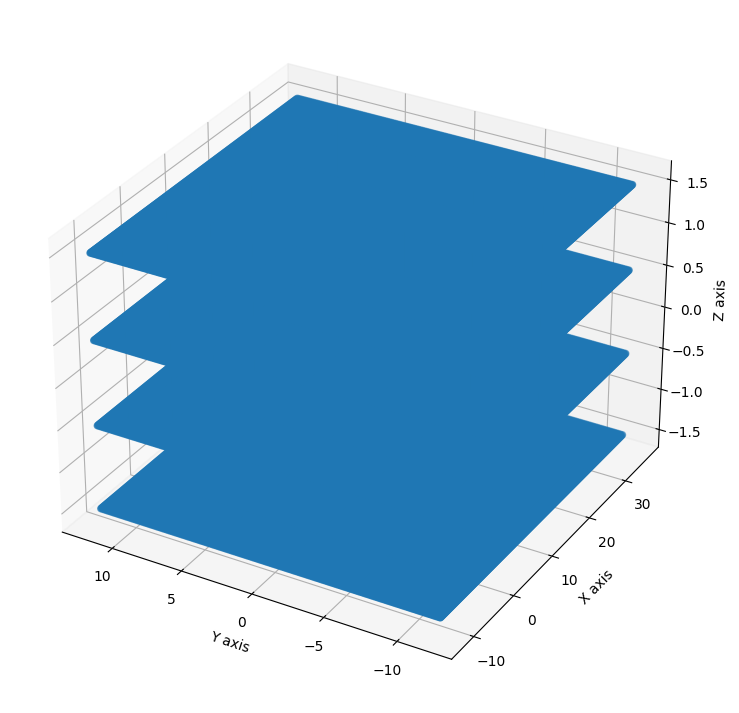

In [205]:
fig = plt.figure(figsize=(9, 9))
ax = fig.add_subplot(111, projection='3d')

xx, yy, zz = voxel_points

ax.scatter(yy, xx, zz)

# ax.set_xlim(0, 319)
# ax.set_ylim(0, 159)
# ax.set_zlim(-2, 2)

ax.set_xlim(ax.get_xlim()[::-1])

ax.set_xlabel('Y axis')
ax.set_ylabel('X axis')
ax.set_zlabel('Z axis')

# 显示图形
plt.show()

In [102]:
# FAST BEV (Voxel to Image)
# for each coordinate from voxel, get the corresponding coordinate in the image depth

voxel_grid = np.zeros((4, 320, 160))
Z, X, Y = voxel_grid.shape
D, V, U = FE.shape[:3]

voxel_range = np.array([
    [-2, 2],
    [36, -12],
    [12, -12]
])

fx = X / (voxel_range[1][1] - voxel_range[1][0])
fy = Y / (voxel_range[2][1] - voxel_range[2][0])
fz = Z / (voxel_range[0][1] - voxel_range[0][0])

cx = - voxel_range[1][0] * fx - 0.5
cy = - voxel_range[2][0] * fy - 0.5
cz = - voxel_range[0][0] * fz - 0.5

for z in range(Z):
    for y in range(Y):
        for x in range(X):
            R_ec @ ego_points[z, y, x] + t_ec

# for d in range(D):
#     for v in range(V):
#         for u in range(U):
#             x, y, z = FE[d, v, u]
#             x = fx * x + cx
#             y = fy * y + cy
#             z = fz * z + cz
#             x_, y_, z_ = round(x), round(y), round(z)
#             if x_ >= 0 and x_ < X and y_ >= 0 and y_ < Y and z_ >= 0 and z_ < Z:
#                 voxel_grid[z_, x_, y_] = 1


(3,)

In [2]:
# def create_frustum(self):
#     """Generate frustum"""
#     # make grid in image plane
#     ogfH, ogfW = self.final_dim
#     fH, fW = ogfH // self.downsample_factor, ogfW // self.downsample_factor
#     d_coords = torch.arange(*self.d_bound,
#                             dtype=torch.float).view(-1, 1,
#                                                     1).expand(-1, fH, fW)  # 对应下采样完的尺寸 fH fW 像素上每个位置的深度范围都是2-58 每隔0.5m,共112个深度值
#     D, _, _ = d_coords.shape
#     x_coords = torch.linspace(0, ogfW - 1, fW, dtype=torch.float).view(
#         1, 1, fW).expand(D, fH, fW) # 先生成0-原像素尺寸大小，均匀分布，共fW个值，表示原像素尺寸下，某个像素位置的x坐标，因为是该变量是表示x维度，对应的高度维度都是一样的值，扩充到fH
#     y_coords = torch.linspace(0, ogfH - 1, fH,
#                                 dtype=torch.float).view(1, fH,
#                                                         1).expand(D, fH, fW) # 与上述表示相同，表示的某个像素位置的y坐标，在宽度维度上扩充fW 
#     paddings = torch.ones_like(d_coords)

#     # D x H x W x 3
#     frustum = torch.stack((x_coords, y_coords, d_coords, paddings), -1)  # 三个变量拼接扩充最后一个维度，表示该下采样完之后的某个像素点对应原图像素坐标（x,y,z） 最后尺寸，112,16,44,4
#     return frustum

# def get_geometry(self, sensor2ego_mat, intrin_mat, ida_mat, bda_mat):
#     """Transfer points from camera coord to ego coord.

#     Args:
#         rots(Tensor): Rotation matrix from camera to ego.
#         trans(Tensor): Translation matrix from camera to ego.
#         intrins(Tensor): Intrinsic matrix.
#         post_rots_ida(Tensor): Rotation matrix for ida.
#         post_trans_ida(Tensor): Translation matrix for ida
#         post_rot_bda(Tensor): Rotation matrix for bda.

#     Returns:
#         Tensors: points ego coord.
#     """
#     batch_size, num_cams, _, _ = sensor2ego_mat.shape

#     # undo post-transformation
#     # B x N x D x H x W x 3
#     points = self.frustum
#     ida_mat = ida_mat.view(batch_size, num_cams, 1, 1, 1, 4, 4)
#     points = ida_mat.inverse().matmul(points.unsqueeze(-1)) # 因为本身生成的像素点points表示的图像坐标，如果有图像层面的增强需要做变换
#     # points = ida_mat.matmul(points.unsqueeze(-1))
#     # cam_to_ego
#     points = torch.cat(
#         (points[:, :, :, :, :, :2] * points[:, :, :, :, :, 2:3],
#             points[:, :, :, :, :, 2:]), 5)  # x,y坐标值和深度值相乘，不太明白

#     combine = sensor2ego_mat.matmul(torch.inverse(intrin_mat)) # 图像坐标系到ego坐标系转换矩阵
#     # combine = sensor2ego_mat.matmul(intrin_mat)
#     points = combine.view(batch_size, num_cams, 1, 1, 1, 4,
#                             4).matmul(points)  # 图像坐标系到ego坐标系的转换
#     if bda_mat is not None:
#         bda_mat = bda_mat.unsqueeze(1).repeat(1, num_cams, 1, 1).view(
#             batch_size, num_cams, 1, 1, 1, 4, 4)
#         points = (bda_mat @ points).squeeze(-1)  # 如果有box的增强要跟图像points的深度和位置做匹配。bda_mat本身是对空间下所有的box的旋转平移的变换矩阵
#     else:
#         points = points.squeeze(-1)
#     return points[..., :3]  # 感觉有点像视锥空间的点